## Thinking Glasses On

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [3]:
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

In [4]:
methods = ['VG', 'COW', 'LNAM']
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            df = frontier_sample_data[eddy]['T'+str(t)][method]
            # Drop Li 2022 measurement of tilt
            if 'TD' in list(df.columns):
                df = df.drop(columns=['TD'])
            # Centralise at surface center # 14 ~ 180m
            central_idx = 0
            if df.shape[0] < central_idx and central_idx != 0:
                central_idx = df.shape[0] // 2 
            df['x'] = df['x'] - df.iloc[central_idx]['x']
            df['y'] = df['y'] - df.iloc[central_idx]['y']
            # Interpolate to equidistant z-layers
            new_depth = np.arange(0, -z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1], 10)
            interp_x = interp1d(-df['Depth'], df['x'], kind='linear', fill_value="extrapolate")
            interp_y = interp1d(-df['Depth'], df['y'], kind='linear', fill_value="extrapolate")
            df = pd.DataFrame({
                "x": interp_x(new_depth),
                "y": interp_y(new_depth),
                "Depth": -new_depth
            })
            df['TD'] = np.hypot(df['x'], df['y'])
            frontier_sample_data[eddy]['T'+str(t)][method] = df

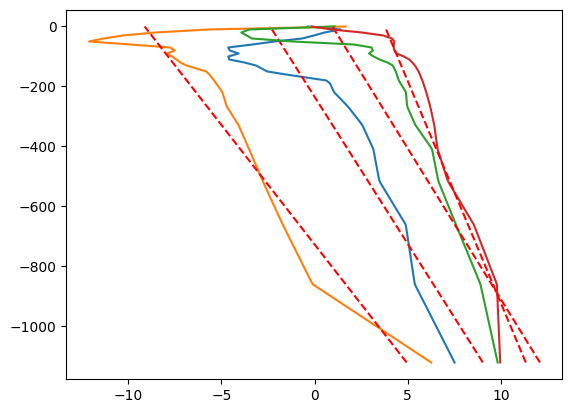

In [5]:
eddy = the_frontier_eddies[2]
method = 'VG'
nob = 0
for t in range(nob, nob+4):
    df = frontier_sample_data[eddy]['T'+str(t)][method]
    
    x = df['x']/1000
    y = df['Depth']

    slope, intercept = np.polyfit(x, y, 1) 
    y_min, y_max = y.min(), y.max()
    x_min = (y_min - intercept) / slope
    x_max = (y_max - intercept) / slope
    fit_x = np.array([x_min, x_max])
    fit_y = slope * fit_x + intercept
    plt.plot(x, y)  
 
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    if r_squared >=.1:
        plt.plot(fit_x, fit_y, color='red', linestyle='--')
    
        

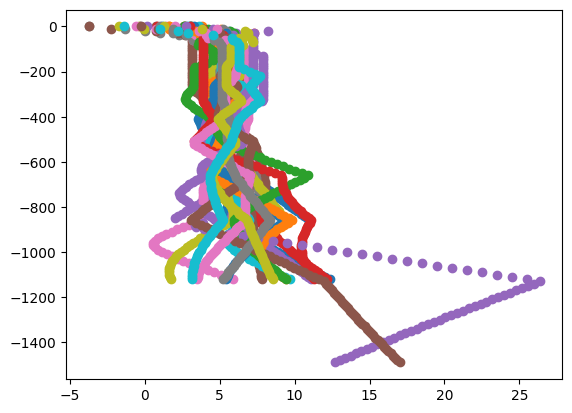

In [117]:
eddy = the_frontier_eddies[0]
method = 'COW'

x1 = frontier_sample_data[eddy]['T0'][method]['TD']/1000 
z1 = frontier_sample_data[eddy]['T0'][method]['Depth']

df_best_shift = pd.DataFrame({'T0': [0, 0]}, index=['i', 'rmse'])
T = 20
# for t in range(T, T+10):
xs, zs = [], []
for t in range(30):
    x2 = frontier_sample_data[eddy]['T'+str(t)][method]['TD']/1000
    z2 = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
    
    df = pd.DataFrame(columns=['i', 'rmse'])
    for i in np.arange(-30, 31, .2):
        x2_shifted = x2 + i
        rmse = np.sqrt(((x1 - x2_shifted) ** 2).mean())
        df.loc[len(df)] = {'i': i, 'rmse': rmse}
    
    i_min_rmse = df.loc[df['rmse'] == df['rmse'].min(), 'i'].iloc[0]
    min_rmse = df['rmse'].min()

    df_best_shift['T'+str(t)] = [i_min_rmse, min_rmse]

    # if min_rmse < 3:
    # plt.plot(x2 + i_min_rmse, z2)
    plt.scatter(x2 + i_min_rmse, z2)
    xs.extend(x2 + i_min_rmse)
    zs.extend(z2)
xs = np.array(xs) - np.min(xs)

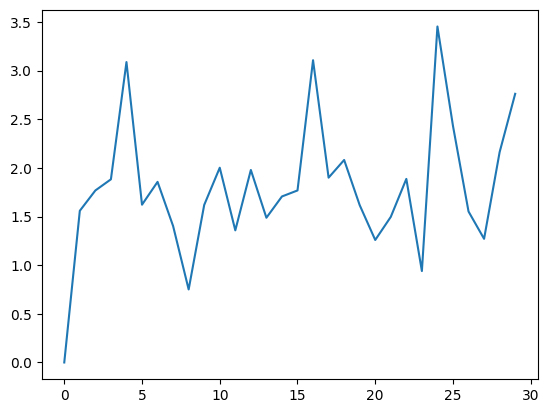

In [104]:
plt.plot(range(30), df_best_shift.loc['rmse'])

In [ ]:
plt.scatter(xs, zs, marker='x')
plt.plot(

ValueError: s must be a scalar, or float array-like with the same size as x and y

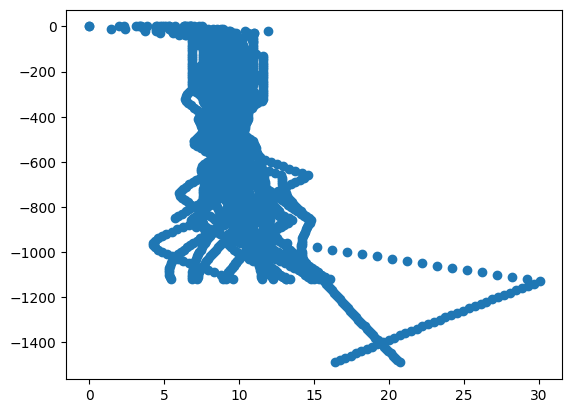

In [148]:
df = pd.DataFrame({'x':xs, 'z': zs})
df = df.groupby('z')['x'].mean().reset_index()

std = df.groupby('z')['x'].mean()

plt.scatter(xs, zs)

std = df.groupby('z')['x'].std().reset_index()
plt.scatter(df['x'], df['z'], color='r', s=std)

In [145]:
std = df.groupby('z')['x'].std().reset_index()

In [149]:
std

,z,x
0,-1490.0,NaN
1,-1480.0,NaN
2,-1470.0,NaN
3,-1460.0,NaN
4,-1450.0,NaN
...,...,...
145,-40.0,NaN
146,-30.0,NaN
147,-20.0,NaN
148,-10.0,NaN


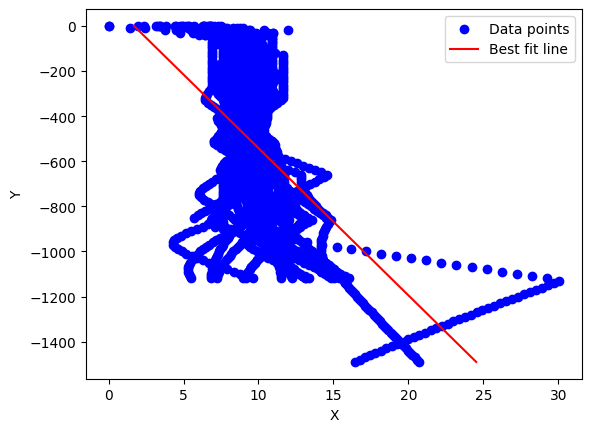

In [118]:
x = xs
y = np.array(zs)
# Fit a line (y = mx + b)
m, b = np.polyfit(x, y, 1)

# Get the bottom and top y-values
y_min, y_max = y.min(), y.max()

# Calculate corresponding x-values for the bottom and top y-values
x_min = (y_min - b) / m
x_max = (y_max - b) / m

# Generate the fitted line from bottom to top y-values
x_fit = np.array([x_min, x_max])
y_fit = m * x_fit + b

# Plot the data and the line of best fit
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_fit, y_fit, color='red', label='Best fit line')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()